In [1]:
import Main
from Analyser import *

In [2]:
modelName = 'Young_Shrub'

In [3]:
# Some PyABC magic to get our set of parameters
from pyabc import (ABCSMC, Distribution, RV, MultivariateNormalTransition)
import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def model(params):
    return Main.generate_and_analyse(modelName, params)

In [16]:
metrics = {  'section_1_slash':(10, 100),
             'section_1_slashr':(10, 100),
             'section_1_plus':(0, 180),
             'section_1_plusr':(0, 180),
             'section_1_decay':(0, 1),
             'section_1_h':(1, 20),
             'section_1_w':(0.1, 2),
             'general_thickness':(0, 5),
             'rule_1_0':(0,1),
             'rule_1_1':(0,1)
          }

In [6]:
prior = Distribution(section_1_slash     =RV("uniform", 10, 100),
                     section_1_slashr    =RV("uniform", 10, 100),
                     section_1_plus      =RV("uniform", 0, 180),
                     section_1_plusr      =RV("uniform", 0, 180),
                     section_1_decay     =RV("uniform", 0, 1),
                     section_1_h         =RV("uniform", 1, 20),
                     section_1_w         =RV("uniform", 0.1, 2),
                     general_thickness   =RV("uniform", 0, 5),
                     rule_1_0            =RV("uniform", 0.5,1),
                     rule_1_1            =RV("uniform", 0.5,1)
                    )

In [7]:
abc = ABCSMC(model, prior, distance)

In [8]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))

In [9]:
def gen_av_target(n):
    target = model({})
    for i in range(n):
        print(i)
        new_metrics = model({})
        for (k,v) in new_metrics.items():
            if k[-3:] == 'xyz':
                x,y,z = target[k]
                x += new_metrics[k][0]
                y += new_metrics[k][1]
                z += new_metrics[k][2]
                target[k] = (x,y,z)
            else:
                target[k] += new_metrics[k]

    for (k,v) in target.items():
        if k[-3:] == 'xyz':
            x,y,z = target[k]
            target[k] = (x/100, y/100, z/100)
        else:
            target[k] /= 100
            
    return target

In [10]:
target = gen_av_target(200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [11]:
target

{'parentAngle_mean': 70.59201025482751,
 'parentAngle_variance': 48.47813351297023,
 'length_mean': 2.9152238285268686,
 'length_variance': 1.6352425751183643,
 'verticalOrientation_mean': 151.6223200185258,
 'verticalOrientation_variance': 73.84688426833083,
 'horizontalOrientation_mean': 355.73535492042606,
 'horizontalOrientation_variance': 209.53159737891622,
 'q1_xyz': (48.91139777439801, 29.22071551285987, 56.97994227480439),
 'q2_xyz': (72.48830072520623, 25.88121635056335, 82.94651143430512),
 'q3_xyz': (62.09225213195821, 28.66164600027995, 70.18850863622689),
 'xyz': (76.08220175435731, 84.08695894024395, 87.32486414207368),
 'trunk_length': 20.557229113595852,
 'totalBiomass': 341.7605600921254}

In [12]:
abc.new(db_path, target)

INFO:History:Start <ABCSMC(id=22, start_time=2019-04-16 20:36:52.165077, end_time=None)>
INFO:Epsilon:initial epsilon is 30.08822242329212


22

In [13]:
history = abc.run(minimum_epsilon=0.5, max_nr_populations=13)

INFO:ABC:t:0 eps:30.08822242329212
INFO:ABC:t:1 eps:18.252171364745067
INFO:ABC:t:2 eps:16.025686400705776
INFO:ABC:t:3 eps:9.899119785155683
INFO:ABC:t:4 eps:9.238063993740685
INFO:ABC:t:5 eps:8.416702015244264
INFO:ABC:t:6 eps:7.794812124265483
INFO:ABC:t:7 eps:7.521549595918527
INFO:ABC:t:8 eps:7.084001272466642
INFO:ABC:t:9 eps:6.63476419453249
INFO:ABC:t:10 eps:6.076026934056909
INFO:ABC:t:11 eps:5.73577714485852
INFO:ABC:t:12 eps:5.723965854177008
INFO:History:Done <ABCSMC(id=22, start_time=2019-04-16 20:36:52.165077, end_time=2019-04-16 21:03:16.805565)>


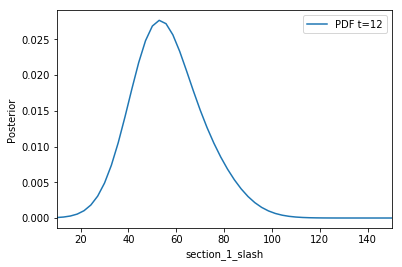

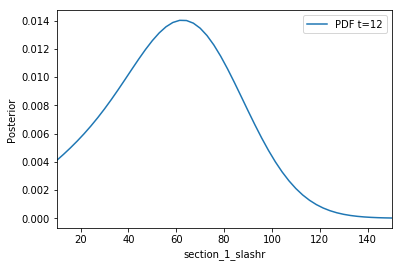

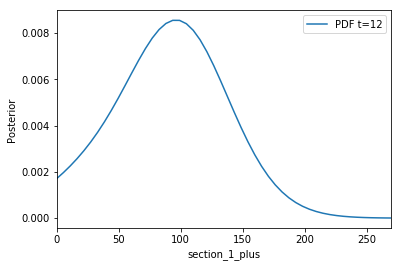

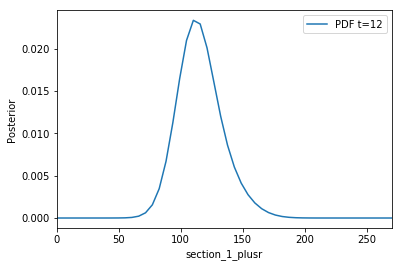

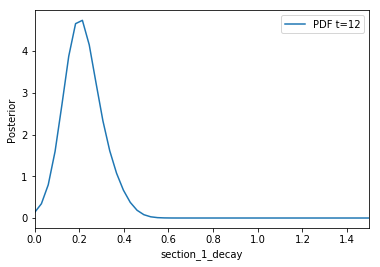

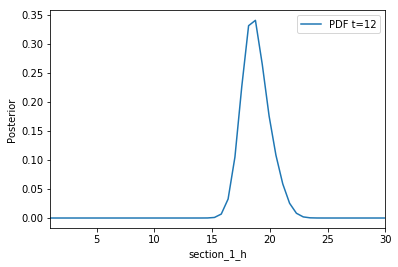

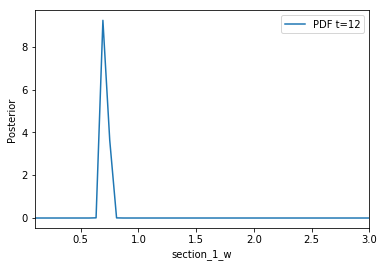

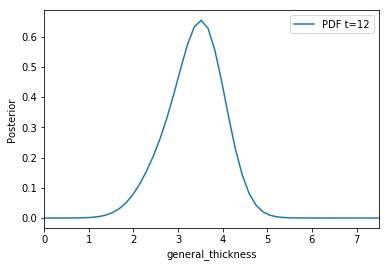

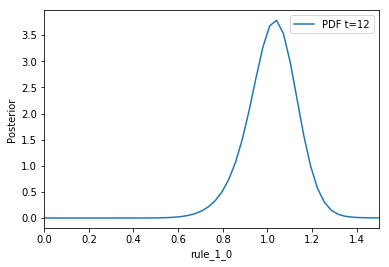

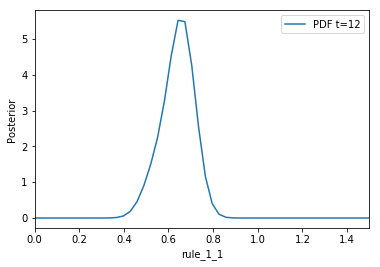

In [17]:
# Visualise results
from pyabc.visualization import plot_kde_1d
for (k,v) in metrics.items():
    fig, ax = plt.subplots()
    for t in range(history.max_t, history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        plot_kde_1d(df, w,
                    xmin=v[0], xmax=1.5*v[1],
                    x=k, ax=ax,
                    label="PDF t={}".format(t))
    ax.legend();